# SwinV2 Transformer on Large Dataset

Training SwinV2 as pretrained network using HAM. 

#### INPUT
- **Training&Validation**: HAM. Duplicates expect for NV class that is downsampled. 

- **Test**: ISIC 2018 Challenge Test Set 

## Installation of libraries

In [1]:
# Install libraries

!pip install torch torchvision tensorboard
!pip install barbar
!pip install torchsummary
!pip install pytorch-ignite
!pip install timm

In [2]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import timm


## Data directories

In [3]:
traindir = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/'
valdir = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/'

print('TRAINING SET ****************')
print('0.MEL ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/0.MEL/')))
print('1.NV ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/1.NV/')))
print('2.BCC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/2.BCC/')))
print('3.AKIEC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/3.AKIEC/')))
print('4.BKL ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/4.BKL/')))
print('5.DF ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/5.DF/')))
print('6.VASC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/6.VASC/')))
print('VALIDATION SET **************')
print('0.MEL ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/0.MEL/')))
print('1.NV ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/1.NV/')))
print('2.BCC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/2.BCC/')))
print('3.AKIEC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/3.AKIEC/')))
print('4.BKL ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/4.BKL/')))
print('5.DF ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/5.DF/')))
print('6.VASC ---> ', len(os.listdir('/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/6.VASC/')))
print('TEST SET ********************')
print('0.MEL ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/0.MEL/')))
print('1.NV ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/1.NV/')))
print('2.BCC ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/2.BCC/')))
print('3.AKIEC ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/3.AKIEC/')))
print('4.BKL ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/4.BKL/')))
print('5.DF ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/5.DF/')))
print('6.VASC ---> ', len(os.listdir('/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/6.VASC/')))

TRAINING SET ****************
0.MEL --->  890
1.NV --->  4322
2.BCC --->  411
3.AKIEC --->  261
4.BKL --->  879
5.DF --->  92
6.VASC --->  113
VALIDATION SET **************
0.MEL --->  223
1.NV --->  1081
2.BCC --->  103
3.AKIEC --->  66
4.BKL --->  220
5.DF --->  23
6.VASC --->  29
TEST SET ********************
0.MEL --->  171
1.NV --->  908
2.BCC --->  93
3.AKIEC --->  43
4.BKL --->  217
5.DF --->  44
6.VASC --->  35


## Data augmentation
#### Dataset consists of 10015 skin deseases images, divided in seven classes, with different sizes.
#### Since we are using SwinV2 Large, to get to 256x256 size, we will first resize to 256x280 and then center crop 256x256 piece.
#### Horizontal/vertical flipping and random rotation are two more advantageous transformations. We will still obtain skin neoplasms that our model should correctly categorise even after rotating and horizontally flipping them since skin neoplasms may take on a variety of forms. These two modifications will be very beneficial to our model. They will enhance the size of our dataset, improve generalisation and avoid overfitting, and strengthen the resilience of our model—especially as some of our classes have very little representation.
#### Since we will be using pretrained SwinV2 Large ImageNet weights to start with, we will use ImageNet style normalization.
#### Batch size will be 64.
####

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 280)),  # Resize
    transforms.RandomCrop((256, 256)),  #  RandomCrop
    # transforms.Resize((224, 280)),
    # transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  

    # Random rotation with range of +/-10% compared to the original size
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((256, 280)),  # Resize 224x300
    transforms.RandomCrop((256, 256)),  # RandomCrop
    # transforms.Resize((224, 280)),
    # torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

In [5]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}
{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}


## Training
#### Model definition
#### Define final layer to a 7 way linear classifier
#### Choose Cross Entropy loss function
#### Adam optimizer (with 0.0001 weight decay)
#### The epoch number will be set to 999 since we will be using early stopping.
####

In [6]:
model = timm.create_model('swinv2_large_window12to16_192to256.ms_in22k_ft_in1k', pretrained=True, num_classes = 7)

In [7]:
num_classes = 7  # number of classes in our model

in_features = model.head.in_features  # Get the input size of the last linear layer
model.head.fc = nn.Linear(in_features, num_classes)

# Optional: Layer freezing
for param in model.parameters():
    param.requires_grad = True # Unfreezing

# Unfreezing of the last layer
for param in model.head.parameters():
    param.requires_grad = True

In [8]:
# Shows info about model
# summary(model, input_size=(3, 224, 224))

In [9]:
import torch

# Create a dummy input tensor of the correct size (e.g., for an image size of 224x224)
dummy_input = torch.randn(1, 3, 256, 256)  # Batch size of 1

# Forward pass through the model
output = model(dummy_input)

print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 7])



#### Early stopping reduces validation loss, and 20 was selected as the patience threshold. This large number is justified because, during the project's development, the model was trained in other experiments. After different experiemnts, we saw the model continues to gradually reduce training loss without overfitting; however, validation loss moves rather stochastically, so in order to avoid stopping the model too soon, a 20-epoch patience period was chosen.
####

In [10]:
# from torch.cuda.amp import GradScaler, autocast
# scaler = GradScaler()

In [11]:
# from timm.loss import LabelSmoothingCrossEntropy
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    print('Start training...')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)
            
        # print('Shape of outputs: ' , outputs.shape)
        # print('Shape of labels: ' , labels.shape)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    print('Start validation...')
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc, all_labels, all_predictions

best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(999):  # Set the number of epochs
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_labels, all_predictions = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        print("Validation loss decreased, saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), r'/home/jovyan/nfs/sbiavaschi/output/swinV2_large_HAM_noDuplNv_pretrained_Gallazzi.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= 20:
        print("Early stopping triggered")
        break


Start training...


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Start validation...
Epoch 1, Train Loss: 0.7637, Train Acc: 0.7214, Val Loss: 0.5699, Val Acc: 0.7994
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 2, Train Loss: 0.4436, Train Acc: 0.8299, Val Loss: 0.4544, Val Acc: 0.8097
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 3, Train Loss: 0.3460, Train Acc: 0.8707, Val Loss: 0.3249, Val Acc: 0.8854
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 4, Train Loss: 0.2626, Train Acc: 0.9031, Val Loss: 0.1993, Val Acc: 0.9238
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 5, Train Loss: 0.2248, Train Acc: 0.9133, Val Loss: 0.1708, Val Acc: 0.9415
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 6, Train Loss: 0.1817, Train Acc: 0.9330, Val Loss: 0.1349, Val Acc: 0.9496
Validation loss decreased, saving model...
Start training...
Start validation...
Ep


## Results
#### Model stopped training after 58 epochs with Early stopping method. 

#### Now we will look at confusion matrix and classification report with Precision, Recall, and F1 score.
####

In [12]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Function to plot training and validation accuracy and loss
def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

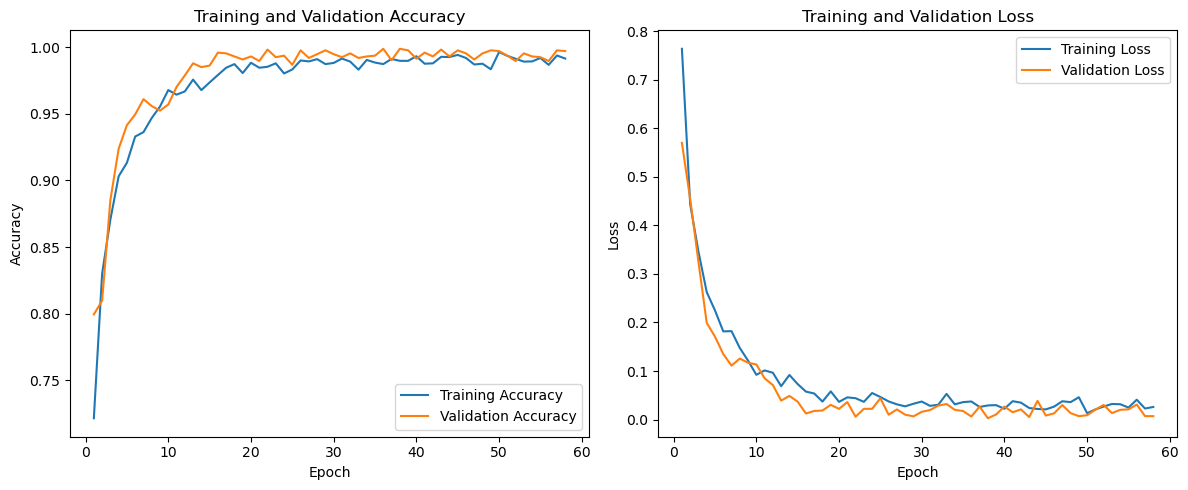

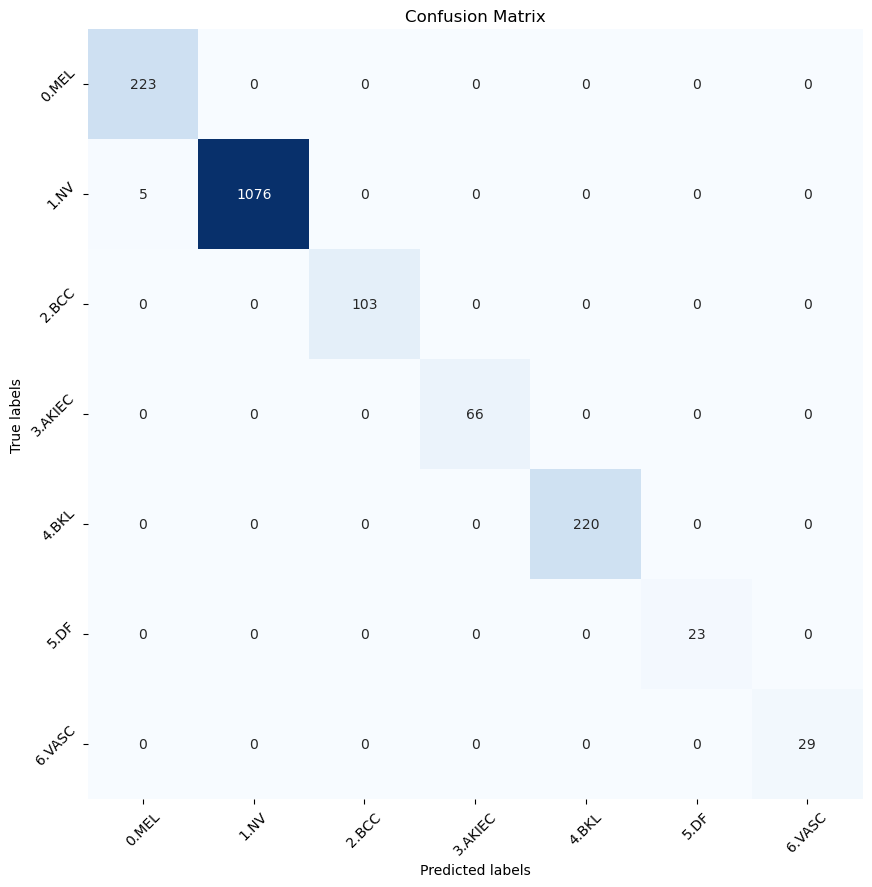

              precision    recall  f1-score   support

       0.MEL       0.98      1.00      0.99       223
        1.NV       1.00      1.00      1.00      1081
       2.BCC       1.00      1.00      1.00       103
     3.AKIEC       1.00      1.00      1.00        66
       4.BKL       1.00      1.00      1.00       220
        5.DF       1.00      1.00      1.00        23
      6.VASC       1.00      1.00      1.00        29

    accuracy                           1.00      1745
   macro avg       1.00      1.00      1.00      1745
weighted avg       1.00      1.00      1.00      1745



In [13]:
# After training completes, plot the metrics and confusion matrix
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Convert all_labels and all_predictions to the correct format if necessary
class_names = val_dataset.classes
plot_confusion_matrix(conf_matrix, class_names)

print(classification_report(all_labels, all_predictions, target_names=class_names))

## Test
#### We use the test dataset discussed in the paper (HAM Test) to see how the model ranks never-before-seen images. The dataset consists of 1511 images divided into seven classes. 
####

In [14]:
testdir = r'/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/'

In [15]:
test_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Resize((256, 300)),
    torchvision.transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_dataset = datasets.ImageFolder(
    testdir, transform=test_transforms)

In [16]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True,
    pin_memory=False, drop_last=False)

In [17]:
print(test_dataset.class_to_idx)

{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}


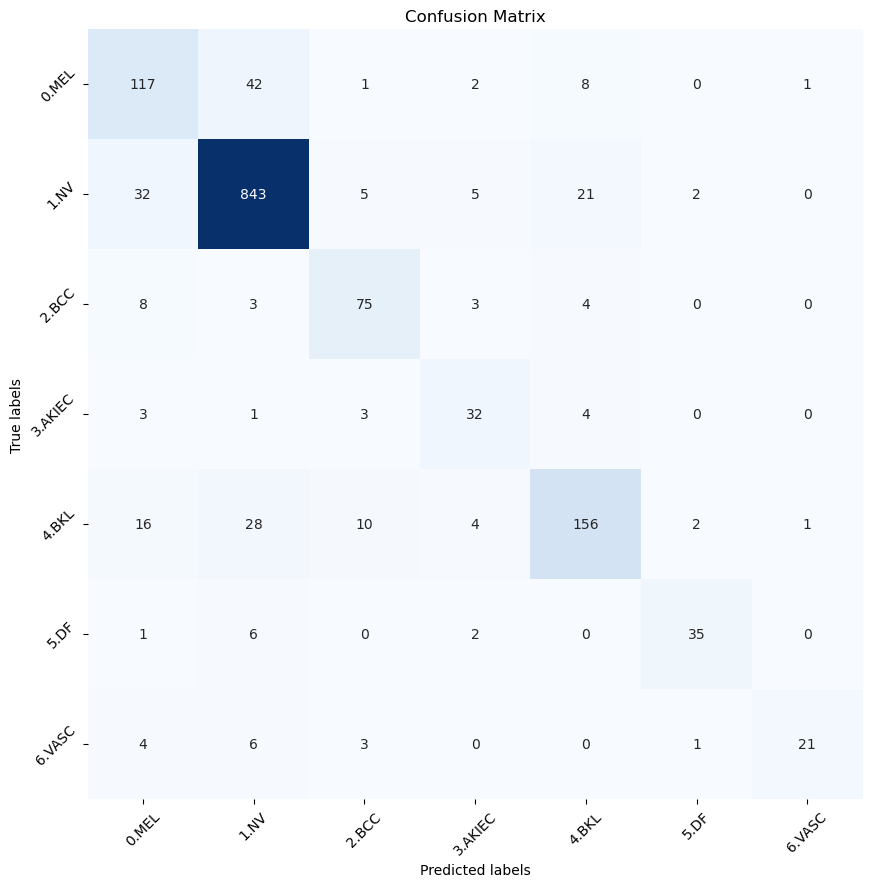

              precision    recall  f1-score   support

       0.MEL       0.65      0.68      0.66       171
        1.NV       0.91      0.93      0.92       908
       2.BCC       0.77      0.81      0.79        93
     3.AKIEC       0.67      0.74      0.70        43
       4.BKL       0.81      0.72      0.76       217
        5.DF       0.88      0.80      0.83        44
      6.VASC       0.91      0.60      0.72        35

    accuracy                           0.85      1511
   macro avg       0.80      0.75      0.77      1511
weighted avg       0.85      0.85      0.85      1511



In [18]:
import torchvision.models as models

num_classes = 7

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = timm.create_model('swinv2_large_window12to16_192to256.ms_in22k_ft_in1k', pretrained=False) # pretrained=False since we'll load custom weights

# Modify the last layer to match the training architecture
in_features = model.head.in_features  # Get the input size of the last linear layer
model.head.fc = nn.Linear(in_features, num_classes)  # Replace the old layer with a new one

# Load the trained model weights
model_path = '/home/jovyan/nfs/sbiavaschi/output/swinV2_large_HAM_noDuplNv_pretrained_Gallazzi.pt'
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device
model = model.to(device)

# Make sure to put the model in evaluation mode
model.eval()

predlist_test=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_test=torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc_test = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        model.eval()  # Evaluation modality
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)
        _, preds = torch.max(outputs, 1)

        # Add batch prediction results
        predlist_test = torch.cat([predlist_test, preds.view(-1).cpu()])
        lbllist_test = torch.cat([lbllist_test, classes.view(-1).cpu()])
        predlistauc_test = torch.cat([predlistauc_test, nn.functional.softmax(outputs, dim=1).cpu()])

# Conversion of tensors to numpy for further processing
predlist_test = predlist_test.numpy()
lbllist_test = lbllist_test.numpy()
predlistauc_test = predlistauc_test.numpy()

# Confusion matrix, classification report

# Confusion Matrix
conf_matrix = confusion_matrix(lbllist_test, predlist_test)
# Convert all_labels and all_predictions to the correct format if necessary
class_names = test_dataset.classes
plot_confusion_matrix(conf_matrix, class_names)

print(classification_report(lbllist_test, predlist_test, target_names=class_names))

## IMPORTANT: the result values are in decimal values. To obtain the exactly same value presented in the paper (84.64) you need to sum all the values on the diagonal and divid the result to 1511.

### Accuravy_value_in_paper = (117+843+75+32+156+35+21) / 1511 --> 84.64